<div style="float: block; text-align: center; line-height: 1.7em">
    <span style="font-size: 2em; font-weight: bold"> Fatigue-Sleepiness in Irregular Workloads for Pilots </span><br>
    <span style="font-size: 1.5em; font-weight: bold"> Statistical Modelling - Perceived Fatigue </span><br>
</div>

---

### Table of contents

##### [1. Loading required libraries](#section1)
 
##### [2. Loading Data](#section2)

##### [3. Preparing Data to Regression Analysis](#section3)

###### [3.1. Counting and Removing NaN rows](#section31)

##### [4. Regression Analysis](#section4)

###### [4.1. Counting and Removing NaN rows](#section41)

###### [4.2. First Iteration](#section42)

###### [4.3. Second Iteration](#section43)

###### [4.4. Third Iteration](#section44)

###### [4.5. Fourth Iteration](#section45)


---

# 1. Loading required libraries <a name="section1"></a>

In [1]:
import os as os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.anova import AnovaRM

import statsmodels.api as sm
import statsmodels.formula.api as smf

---

# 2. Loading Data <a name="section2"></a>

In [2]:
file = os.path.join('data','processed_to_regression.csv')
df = pd.read_csv(file)

df.head(5)

,Id,Record_time_stamp,kss,sps,time_fill_kss_sps,workload_moment,workload_type,workload_type_prev_es,workload_type_prev_nt,workload_length,...,Flight_hours,education,marital_status,Time_displacement,Age,Disturbed_sleep,Awakening,Sleep_Fatig,Classification,select
0,P01,07/12/2021 12:21,5,4.0,AFT,start,others,0,0,8.883333,...,17000.0,univ,married,60,49,13,9,14,INT,1
1,P01,07/12/2021 19:57,5,5.0,EVE,middle,others,0,0,8.900000,...,17000.0,univ,married,60,49,13,9,14,INT,1
2,P01,08/12/2021 00:15,7,6.0,NI,end,others,0,0,8.916667,...,17000.0,univ,married,60,49,13,9,14,INT,1
3,P01,09/12/2021 05:20,7,5.0,NI,start,early-start,0,0,5.450000,...,17000.0,univ,married,60,49,13,9,14,INT,1
4,P01,09/12/2021 09:50,4,3.0,MOR,middle,early-start,0,0,5.466667,...,17000.0,univ,married,60,49,13,9,14,INT,1


In [3]:
working_df = df[df['workload_moment'].isin(['start','middle','end'])]
working_df.head(5)

,Id,Record_time_stamp,kss,sps,time_fill_kss_sps,workload_moment,workload_type,workload_type_prev_es,workload_type_prev_nt,workload_length,...,Flight_hours,education,marital_status,Time_displacement,Age,Disturbed_sleep,Awakening,Sleep_Fatig,Classification,select
0,P01,07/12/2021 12:21,5,4.0,AFT,start,others,0,0,8.883333,...,17000.0,univ,married,60,49,13,9,14,INT,1
1,P01,07/12/2021 19:57,5,5.0,EVE,middle,others,0,0,8.900000,...,17000.0,univ,married,60,49,13,9,14,INT,1
2,P01,08/12/2021 00:15,7,6.0,NI,end,others,0,0,8.916667,...,17000.0,univ,married,60,49,13,9,14,INT,1
3,P01,09/12/2021 05:20,7,5.0,NI,start,early-start,0,0,5.450000,...,17000.0,univ,married,60,49,13,9,14,INT,1
4,P01,09/12/2021 09:50,4,3.0,MOR,middle,early-start,0,0,5.466667,...,17000.0,univ,married,60,49,13,9,14,INT,1


---

# 3. Preparing Data to Regression Analysis <a name="section3"></a>

The sps and kss scales were taken along each workloads in three moments, at start, at middle and at end. As the pilots workloads are irregular, these three moments can occur at different hours along the day in the EM, MOR, AFT, EVE, NI.

To tackle this kind of problem a mixed model with control in participant is ideal, i.e. a model whith a random intercept for each participant. However, the measurements were taken irregularly along various hours of the day, so we will assume another random intercept and a random slope in the variable time the participants filled kss and sps scales.

## 3.1. Counting and removing nan rows <a name="section31"></a>

### 3.1.1. Function to diplay side by side

In [5]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").format(precision=2)\
                          .set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

### 3.1.2. Getting NaN values number per column

In [6]:
wsm = working_df.isna().sum()
display_side_by_side([pd.DataFrame(wsm[0:6]), pd.DataFrame(wsm[6:12]), pd.DataFrame(wsm[12:18]),pd.DataFrame(wsm[18:])],
                    ['(a)','(b)','(c)','(d)'])

,0
Id,0
Record_time_stamp,0
kss,0
sps,1
time_fill_kss_sps,0
workload_moment,0
,0
workload_type,0
workload_type_prev_es,0
workload_type_prev_nt,0


As we can see few values of NaN is present in our data set, once we have more than 1k rows, we can remove these rows without great impacts in forward analysis

### 3.1.3. Removing NaN rows

In [7]:
working_df = working_df.dropna()

wsm = working_df.isna().sum()
print(''); print('')
display_side_by_side([pd.DataFrame(wsm[0:6]), pd.DataFrame(wsm[6:12]), pd.DataFrame(wsm[12:18]),pd.DataFrame(wsm[18:])],
                    ['(a)','(b)','(c)','(d)'])
print(''); print('')

,0
Id,0
Record_time_stamp,0
kss,0
sps,0
time_fill_kss_sps,0
workload_moment,0
,0
workload_type,0
workload_type_prev_es,0
workload_type_prev_nt,0


### 3.1.4. Re-scaling some variables

In [8]:
working_df['flight_hours'] = working_df['Flight_hours'].copy()/1000
working_df['age'] = working_df['Age'].copy()/10
working_df['time_displacement'] = working_df['Time_displacement'].copy()/60

**Now the data is ready for analysis!**

---

# 4. Regression Analysis <a name="section4"></a>

Given the experimental design discussed in [Feature_Engineering.ipynb](Feature_Engineering.ipynb),  we choose a mixed logistic model or multilevel logistic model

<p style="text-align: center;"> $g(x_{ij},\beta_{0i},\beta_1, \beta_s) = \beta_{0i}+\beta_{1i}x_1 + x_{ij}^T\beta_s$  (level 1) </p>
<p style="text-align: center;"> $\beta_{0i} = \beta_0 + \alpha_i$  (level 2, random intercept) </p>
<p style="text-align: center;"> $\beta_{1i} = \beta_1 + \tau_i$  (level 2, random slope) </p>

where $\alpha_i \sim N(0,\sigma_\alpha^2)$ and $\tau_i \sim N(0,\sigma_\tau^2)$ with $\alpha_i \perp \tau_i$.

In our setting, the random slope is due to time the participants filled the scales and the random intercept is due to participant cluster and time the participant filled the scales.

## 4.1. Function to codify formula in statsmodel standard <a name="section41"></a>

In [9]:
def get_formula(covariates, target, prnt = False):
    formula = f'{target}~'
    for cvt in covariates:
        formula += cvt+'+'
    formula = formula[:-1]
    if prnt:
        print(f'formula:\n{formula}')
    return formula

## 4.2. First Iteration <a name="section42"></a>

In [10]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

covariates = ['workload_moment','workload_type','time_fill_kss_sps','workload_type_prev_es','workload_type_prev_nt',
              'workload_length','sleep_duration','time_awake','Position','Num_Sons','flight_hours','education',
              'marital_status','time_displacement','age','Num_Sons','Classification']

formula = get_formula(covariates, 'sps')

md = smf.mixedlm(formula, working_df, groups=working_df["Id"], re_formula = 'time_fill_kss_sps')
mdf = md.fit()
print(mdf.summary())

                               Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               sps       
No. Observations:                1014                  Method:                           REML      
No. Groups:                      43                    Scale:                            0.9162    
Min. group size:                 8                     Log-Likelihood:                   -1491.9473
Max. group size:                 39                    Converged:                        Yes       
Mean group size:                 23.6                                                              
---------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------------
Intercept                      

Using the Wald test (P>|z|) at level of 5%, we can reject variables related to previous workloads (workload_type_es and workload_type_nt) and Position. The variable workload_type will be recategorized, meaning just an indicator of night routines.

So, follows the second iteration.

## 4.3. Second Iteration <a name="section43"></a>

In [11]:
covariates = ['workload_moment','workload_type','time_fill_kss_sps',
              'workload_length','sleep_duration','time_awake','Num_Sons','flight_hours','education',
              'marital_status','time_displacement','age','Num_Sons','Classification']

formula = get_formula(covariates, 'sps')

working_df2 = working_df.copy()
working_df2['workload_type'] = working_df2['workload_type'].apply(lambda x: 'others' if x=='early-start' else x)

md = smf.mixedlm(formula,working_df2, groups=working_df2["Id"], re_formula = 'time_fill_kss_sps')
# equivalent coded in r as y~x1+x2+..+xn+(1+xn|Id)

mdf = md.fit()
print(mdf.summary())

                               Mixed Linear Model Regression Results
Model:                           MixedLM               Dependent Variable:               sps       
No. Observations:                1014                  Method:                           REML      
No. Groups:                      43                    Scale:                            0.9161    
Min. group size:                 8                     Log-Likelihood:                   -1489.7588
Max. group size:                 39                    Converged:                        Yes       
Mean group size:                 23.6                                                              
---------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------------------------
Intercept                      

As we can see, all variables considered is found significant at the level of 5%. However, some more analysis is found needed to choose this model as the best model or a parsimonious model.

At first we will plot the model coefficients in terms of odds ratio and evaluate if it is needed to collapse some categorical variable such as "workload_moment" or "workload_type". 

Text(0.5, 1.0, 'Perception of Fatigue Odds ratio')

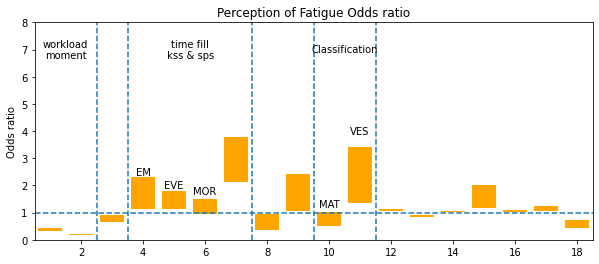

In [12]:
fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,4))

odds_var = np.exp(mdf.conf_int())[1:19]
#x = odds_var.index
x = np.linspace(1,len(odds_var),len(odds_var))
y_bottom = np.array(odds_var[0])
y_diff = np.array(odds_var[1]) - np.array(odds_var[0])
ax.bar(x, y_diff, bottom=y_bottom, color = 'orange')
ax.vlines(x = 2.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.vlines(x = 3.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.vlines(x = 7.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.vlines(x = 9.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.vlines(x = 11.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.hlines(xmin = 0, xmax = 20, y = 1, linestyles='dashed')
ax.text(1.5,7,'workload\nmoment', horizontalalignment='center',verticalalignment='center')
ax.text(5.5,7,'time fill\n kss & sps', horizontalalignment='center',verticalalignment='center')
ax.text(10.5,7,'Classification', horizontalalignment='center',verticalalignment='center')
ax.text(4,2.5,'EM', horizontalalignment='center',verticalalignment='center')
ax.text(5,2,'EVE', horizontalalignment='center',verticalalignment='center')
ax.text(6,1.8,'MOR', horizontalalignment='center',verticalalignment='center')
ax.text(10,1.3,'MAT', horizontalalignment='center',verticalalignment='center')
ax.text(11,4,'VES', horizontalalignment='center',verticalalignment='center')
ax.set_ylim([0,8])
ax.set_xlim([0.5, 18.5])
ax.set_ylabel('Odds ratio')
ax.set_title('Perception of Fatigue Odds ratio')

Figure above presents the 95% odds ratio interval for all covariates.

* For time the participant fill sps scale covariate, we can see a lot of overlapping between categories EM and EVE, indicating that these two categories can be merged into a single category. However, due to the interpretability of the result (EM does not follow EVE period), we will keep the variable as it is at this moment;

* For Morning (MOR) category observing the bar chart above and the summary table, we see that the coefficient ranges from negative to positive value indicating that, there is not statistical evidence of difference between the MOR and the baseline (AFT) category, in terms of perception of fatigue. As AFT follows MOR period, by the nature of problem, these two categories can be merged into a single category;

* The same is observed fot the MAT category in chronotype variable. So, the MAT and INT category will be merged into MAT_INT.

So, follows the third iteration.

## 4.4. Third Iteration <a name="section44"></a>

In [13]:
covariates = ['workload_moment','workload_type','time_fill_kss_sps','workload_length',
              'time_awake','time_displacement','flight_hours','Position',
              'marital_status','education','Classification', 'age','sleep_duration']

formula = get_formula(covariates, 'sps')

working_df3 = working_df2.copy()
working_df3['Classification'] = working_df3['Classification'].copy().apply(lambda x: 'MAT_INT' if x in ['MAT','INT'] else x)
working_df3['time_fill_kss_sps'] = working_df3['time_fill_kss_sps'].copy().apply(lambda x: 'AFT_MOR' if x in ['AFT','MOR'] else x) 

md3 = smf.mixedlm(formula,working_df3, groups=working_df3["Id"], re_formula = 'time_fill_kss_sps')
# equivalent coded in r as y~x1+x2+..+xn+(1+xn|Id)

mdf3 = md3.fit()
print(mdf3.summary())

                              Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               sps       
No. Observations:               1014                  Method:                           REML      
No. Groups:                     43                    Scale:                            0.9373    
Min. group size:                8                     Log-Likelihood:                   -1495.3118
Max. group size:                39                    Converged:                        Yes       
Mean group size:                23.6                                                              
--------------------------------------------------------------------------------------------------
                                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

The wald test, presents that the variables:

* Marital status presents high p-value (0.364)

So in the next iteration these variable will be taken, considering a significance level of 0.05.

## 4.5. Fourth Iteration - Parsimonious Model <a name="section45"></a>

In [14]:
covariates = ['workload_moment','workload_type','time_fill_kss_sps','workload_length',
              'time_awake','time_displacement','flight_hours','Position',
              'Classification','age','sleep_duration','education']

formula = get_formula(covariates, 'sps')

working_df4 = working_df3.copy()

md4 = smf.mixedlm(formula, working_df4, groups=working_df3["Id"], re_formula = 'time_fill_kss_sps')
# equivalent code in r glmer lib as y~x1+x2+..+xn+(1+xn|Id)

mdf4 = md4.fit()
print(mdf4.summary())

                              Mixed Linear Model Regression Results
Model:                          MixedLM               Dependent Variable:               sps       
No. Observations:               1014                  Method:                           REML      
No. Groups:                     43                    Scale:                            0.9364    
Min. group size:                8                     Log-Likelihood:                   -1494.9034
Max. group size:                39                    Converged:                        Yes       
Mean group size:                23.6                                                              
--------------------------------------------------------------------------------------------------
                                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Intercept                                

Above it is shown the output of the chosen model!

### 4.5.1. Coefficients Interpretation

Logistic model coefficients can be interpreted as odds ratio. Due to the link function, odds ratio is obtained through exponentiation of the coefficient, so:

<p style="text-align: center;"> odds ratio = exp(coefficient) </p><br>


we will apply this rationale to all fixed effects and random slope parameters.

Text(0.5, 1.0, 'Perception of Sleepiness Odds ratio - Parsimonious Model')

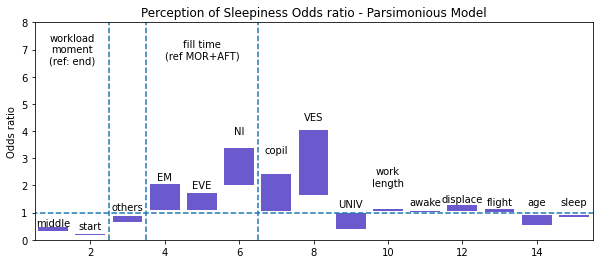

In [16]:
fig,ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,4))

odds_var = np.exp(mdf4.conf_int())[1:16]
#x = odds_var.index
x = np.linspace(1,len(odds_var),len(odds_var))
y_bottom = np.array(odds_var[0])
y_diff = np.array(odds_var[1]) - np.array(odds_var[0])
ax.bar(x, y_diff, bottom=y_bottom, color = 'slateblue')
ax.vlines(x = 2.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.vlines(x = 3.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.vlines(x = 6.5, ymin = 0, ymax = 9, linestyles='dashed')
ax.hlines(xmin = 0, xmax = 20, y = 1, linestyles='dashed')
ax.text(1.5,7,'workload\nmoment\n(ref: end)', horizontalalignment='center',verticalalignment='center')
ax.text(5,7,'fill time\n(ref MOR+AFT)', horizontalalignment='center',verticalalignment='center')
ax.text(1,.6,'middle', horizontalalignment='center',verticalalignment='center')
ax.text(2,.5,'start', horizontalalignment='center',verticalalignment='center')
ax.text(3,1.2,'others', horizontalalignment='center',verticalalignment='center')
ax.text(4,2.3,'EM', horizontalalignment='center',verticalalignment='center')
ax.text(5,2,'EVE', horizontalalignment='center',verticalalignment='center')
ax.text(6,4,'NI', horizontalalignment='center',verticalalignment='center')
ax.text(7,3.3,'copil', horizontalalignment='center',verticalalignment='center')
ax.text(8,4.5,'VES', horizontalalignment='center',verticalalignment='center')
ax.text(9,1.3,'UNIV', horizontalalignment='center',verticalalignment='center')
ax.text(10,2.3,'work\nlength', horizontalalignment='center',verticalalignment='center')
ax.text(11,1.4,'awake', horizontalalignment='center',verticalalignment='center')
ax.text(12,1.5,'displace', horizontalalignment='center',verticalalignment='center')
ax.text(13,1.4,'flight', horizontalalignment='center',verticalalignment='center')
ax.text(14,1.4,'age', horizontalalignment='center',verticalalignment='center')
ax.text(15,1.4,'sleep', horizontalalignment='center',verticalalignment='center')
ax.set_ylim([0,8])
ax.set_xlim([0.5, 15.5])
ax.set_ylabel('Odds ratio')
ax.set_title('Perception of Sleepiness Odds ratio - Parsimonious Model')

Figure above presents the 95% confidence bounds of the coefficients as odds ratio.

In [19]:
# getting odds ratio and confidence bounds
odds = pd.DataFrame( {'odds':np.exp(mdf4.params)[1:16], 'lower':odds_var[0], 'upper':odds_var[1] } )

Categorical variables such as Workload Moment and Time the participant filled the scales are composed by more than one category, and the odds ratio are presented in relation to a give reference level, to address this issue it is possible to obtain a matrix with all the possible combination of reference levels.

Bellow the coefficients of Workload Moment and Time the participants filled the scale is presented for all possible reference levels.

In [20]:
def get_odds_matrix(temp, upper, lower, cats):
    x = [[f'{temp[j]/temp[i]:2.2f} [{min( upper[j]/upper[i],lower[j]/lower[i]):2.2f}, {max( upper[j]/upper[i],lower[j]/lower[i]):2.2f}]' for j in range(len(temp))] for i in range(len(temp))]
    return pd.DataFrame(x, columns = cats, index = cats)

temp =  [odds.odds[0:2][1],odds.odds[0:2][0], 1]
upper = [odds.upper[0:2][1],odds.upper[0:2][0], 1]
lower = [odds.lower[0:2][1],odds.lower[0:2][0], 1]
cats = ['start','middle','end'];
moment = get_odds_matrix(temp, upper,lower, cats)

temp = [odds.odds[3:6][0], 1, odds.odds[3:6][1], odds.odds[3:6][2]]
upper = [odds.upper[3:6][0], 1, odds.upper[3:6][1], odds.upper[3:6][2]]
lower = [odds.lower[3:6][0], 1, odds.lower[3:6][1], odds.lower[3:6][2]]
cats = ['EM','MOR+AFT','EVE','NI']
fill = get_odds_matrix(temp, upper, lower, cats)

print(''); print('')
display_side_by_side([moment, fill],['(a) Workload Moment','(b) time the participant filled kss and sps scales'])
print(''); print('')

Above, the coefficients in terms of odds ratio for workload moment and time the participants filled the scales are presented, rows represent the reference level and columns represent the category to be compared.

**For workload moment we have:**

* The odds of perception of severe fatigue at middle of workloads are 107% (OR=2.07 [2.07,2.07]) higher than at start of workloads, with all other covariates held constant;

* The odds of perception of severe fatigue at the end of workloads are 422% (OR=5.22 [4.46,6.09]) higher than at the start of workload, with all other covariates held constant;

* The odds of perception severe fatigue at the end of workloads are 152% (OR=2.52 [2.15,2.94]) higher than at the middle of workload, with all other covariates held constant.

**For time the participant filled the kss and sps scales we have:**

* The odds of perception of severe fatigue at early-mornings are 50% (OR=1.50 [1.10,2.05]) higher than at mornings or afternoons, with all other covariates held constant;

* The odds of perception of severe fatigue at evenings are 38% (OR=1.38 [1.10,1.72]) higher than at mornings or afternoons, with all other covariates held constant;

* The odds of perception of severe fatigue at nights are 160% (OR=2.60 [2.01,3.37]) higher than at mornings or afternoons, with all other covariates held constant.

In [35]:
temp = pd.DataFrame( {'odds':odds.odds[[2,6,7,8,9,10,11,12,13,14]], 'lower':odds.lower[[2,6,7,8,9,10,11,12,13,14]], 'upper':odds.upper[[2,6,7,8,9,10,11,12,13,14]] })

temp.odds[0], temp.lower[0], temp.upper[0] = 1/temp.odds[0] , 1/temp.upper[0], 1/temp.lower[0]
temp.odds[3], temp.lower[3], temp.upper[3] = 1/temp.odds[3] , 1/temp.upper[3], 1/temp.lower[3]
temp.odds[8], temp.lower[8], temp.upper[8] = 1/temp.odds[8] , 1/temp.upper[8], 1/temp.lower[8]
temp.odds[9], temp.lower[9], temp.upper[9] = 1/temp.odds[9] , 1/temp.upper[9], 1/temp.lower[9]

temp = temp.rename(index = {'workload_type[T.others]':'workload_type[T.night]'})
temp = temp.rename(index = {'education[T.univ]':'education[T.non_univ]'})
temp = temp.rename(index = {'sleep_duration':'-sleep_duration'})
temp = temp.rename(index = {'age':'-age'})

print(''); print('')
display_side_by_side([temp[0:4], temp[4:]],['(a) Dicotomous ','(b) Continuous'])
print(''); print('')

,odds,lower,upper
workload_type[T.night],1.34,1.15,1.55
Position[T.COPIL],1.59,1.05,2.42
Classification[T.VES],2.58,1.65,4.03
education[T.non_univ],1.62,1.01,2.60
,odds,lower,upper
workload_length,1.09,1.05,1.12
time_awake,1.04,1.02,1.07
time_displacement,1.16,1.07,1.26
flight_hours,1.08,1.04,1.13
-age,1.41,1.10,1.81


**For dicotomous variables we have:**

* The odds of perception of severe fatigue for workloads comprehending nights are 34% (OR=1.34 [1.15, 1.55]) higher than other workload modalities, with all other covariates held constant;

* The odds of perception of severe fatigue for co-pilots are 59% (OR=1.59 [1.05, 2.42]) higher than for commanders, with all other covariates held constant;

* The odds of perception of severe fatigue for chronotypes vespertines are 158% (OR=2.58 [1.65, 4.03]) higher than for chronotypes matutines or intermediaries, with all other covariates held constant;

* The odds of perception of severe fatigue for participants without superior education are 62% (OR=1.62 [1.01,2.60]) higher than for participants with superior education, with all other covariates held constant.

**For continuous variables we have:**

* For workloads duration, there is an 9% (OR=1.09 [1.05, 1.12]) increase in the odds of perceiving svere fatigue in individuals that works 1 hour more compared to any workload duration baseline, with all other covariates held constant;

* For time awake before the workload, there is an 4% (OR=1.04 [1.02, 1.07]) increase in the odds of perceiving severe fatigue in individuals that were 1 hour awake before workload compared to any time awake before workload baseline, with all other covariates held constant;

* For travel time home to work, there is an 16% (OR=1.16 [1.07, 1.26]) increase in the odds of perceiving severe fatigue in individuals that take 1 hour more to travel from home to work compared to any travel time baseline, with all other covariates held constant;

* For fligh hours, there is an 8% (OR=1.08 [1.04, 1.13])  increase in the odds of perceiving severe fatigue in individuals with 1,000 more flight hours compared to any flight hours baseline, with all other covariates held constant;

* For the age, there is an 41% (OR=1.41 [1.10, 1.81]) increase in the odds of perceiving severe fatigue in individuals 10 years younger compared to any age baseline, with all other covariates held constant.

* For the sleep duration before the workload, there is an 13% (OR=1.13 [1.09, 1.18]) increase in the odds of perceiving severe fatigue in individuals who sleep 1 hour less compared to any sleep duration baseline, with all other covariates held constant.

### 4.5.2. Miscellaneous

#### 4.5.2.1. Variability intra clusters

The variability inside clusters, i.e. participants and time the participant filled kss, can be assessed through a Median Odds Ratio (MOR). Following Hosmer and Lemeshow seminal book entitled "Applied Logistical Regression", we MOR is given by:

<p style="text-align: center;"> $\hat{MOR} = exp(z_{0.75}\sqrt[]{2 \hat{\sigma}^{2}})$ </p><br>

so, for random intercepts we have:

(Obs: For the time the individuals filled kss scale, does not make practical sense to compute MOR not conditioned to participant, once the time random covariate is clutered inside participant cluster, so we used covariance between participant and its corresponding time rather than the time variance.)

In [36]:
index = ['Participant', 'EM', 'EVE', 'NI']
# It does not make practical sense to access variability in individual time when participant filled kss!
sigma_squared = np.array([0.266, -0.024, -0.032, -0.170])
mor = np.exp(0.6745*np.sqrt(2*np.exp(sigma_squared)))
pd.DataFrame({'':index, 'mor':mor}).set_index('').transpose().round(2)

,Participant,EM,EVE,NI
mor,2.97,2.57,2.56,2.4


Above the median odds ratio (MOR) is presented for all random intercepts.

The interpretation of this quantity is the following:

* For two randomly chosen individuals with the same values of covariates, the median odds ratio for the individual more prone to perceive excessive sleepiness is 197% (MOR = 2.97) higher than for the less prone in all such pairs;

* For two randomly chosen individuals with the same values of covariates, the median odds ratio for the individual more prone to perceive excessive sleepiness is 257% (MOR = 2.57) higher than for the less prone in all such pairs, conditioned to Early-Morning in relation to Morning or Afternoon periods.

* For two randomly chosen individuals with the same values of covariates, the median odds ratio for the individual more prone to perceive excessive sleepiness is 156% (MOR = 2.56) higher than for the less prone in all such pairs, conditioned to Evening in relation to Morning or Afternoon periods.

* For two randomly chosen individuals with the same values of covariates, the median odds ratio for the individual more prone to perceive excessive sleepiness is 140% (MOR = 2.40) higher than for the less prone in all such pairs, conditioned to Night in relation to Morning or Afternoon periods.